# Imports 

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from osgeo import gdal

import os
import glob
import random

from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import rmse, psnr, uqi, ergas, scc, rase, sam, vifp

In [ ]:
#gloabl variables
global channels 
channels = ['Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2']

In [41]:
# Functions
def get_rgb(img):
    """Return normalized RGB channels from sentinal image"""
    
    rgb_img = img[:, :, [3,2,1]]
    rgb_normalize = np.clip(rgb_img/10000, 0, 0.3)/0.3
    
    return rgb_normalize

def load_test(path):
    """Returns sentinal image, rgb image and label"""
    
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)
    rgb_img = get_rgb(stack_img)
    
    label_path = path.replace("images","labels").replace("image","label")
    label = gdal.Open(label_path).ReadAsArray()
    
    return stack_img, rgb_img, label

    
def channel_filter(img,c=0):
    """Returns given channel from image"""
    img = np.array(img)
    c_img = img[:, :, c]

    return c_img


def plot_channels(img,invert=False):
    
    """Plot all channels of a given image"""
    
    global channels

    fig, axs = plt.subplots(3,4,figsize=(15,10))

    index = 0
    for i in range(3):
        for j in range(4):
            c_img = channel_filter(img,c=index)
            if invert:
                c_img = 255-c_img

            axs[i,j].imshow(c_img,cmap='gray')
            axs[i,j].set_title(channels[index])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

            index +=1

def preprocess(img_input, toggle=[True,True,True]):
        """Preprocess image for edge detection
        toggle: [Equalized histogram, Gaussian blur, Morphological closing]
        """
        img = img_input.copy()
        img = np.array(img)

        # Iterate over bands
        for i in range(12):
                img_i = img[:,:,i]

                # Scale bands between 0 and 255
                img[:,:,i] = cv2.normalize(img[:,:,i], None, 0, 255, cv2.NORM_MINMAX)

                # Equalized histogram
                img_i = np.uint8(img_i)
                if toggle[0]:
                        img_i = cv2.equalizeHist(img_i)


                # Gaussian blur
                if toggle[1]:
                        kernel = (5, 5)
                        img_i = cv2.GaussianBlur(img_i, kernel,0)

                # Morphological closing
                if toggle[2]:
                        kernel = np.ones((5,5),np.uint8)
                        img_i = cv2.morphologyEx(img_i, cv2.MORPH_CLOSE, kernel)
                
                img[:,:,i] = img_i
       
        img = np.uint8(img)
        return img

def canny_ed(img_input, threshold1=100, threshold2=200):

    #Apply canny edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        img_i = cv2.Canny(img_i,threshold1 = threshold1, threshold2 = threshold2)
        img[:,:,i] = img_i

    return img

# Larger edge

In [8]:
def prewitt_label(img_input):
    #Apply prewitt edge detection to image
    img = img_input.copy()
    img = np.array(img)

    kx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]]) 
    ky = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    prewittx = cv2.filter2D(img, -1, kx)
    prewitty = cv2.filter2D(img, -1, ky)
    prewitt_img = prewittx + prewitty

    return prewitt_img

In [29]:
test_path = glob.glob("../../data/SWED/test/images/*")
print(test_path[0])
print(len(test_path))

# Load all images
input = []
rgb = []
labels = []

for path in test_path:
    try:
        img, rgb_img, label = load_test(path)
    
        input.append(img)
        labels.append(label)
        rgb.append(rgb_img)
    except:
        print("Error with image: ", path)

../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif
98


In [48]:
def label_to_edge(label):
    """Converts label to edge image"""
    img = label.copy()

    img = np.array(img*255)
    img = img.astype('uint8')
    img = cv2.Canny(img, 100, 200)

    img = cv2.dilate(img, np.ones((3,3), np.uint8), iterations=1)
    
    return img

In [49]:
# Apply canny to binary maps
edge_reference = [label_to_edge(img) for img in labels]
#edge_reference = [np.uint8(prewitt_label(img)) for img in canny_input]

20


(-0.5, 255.5, 255.5, -0.5)

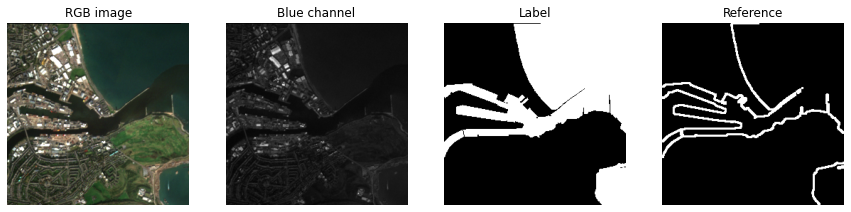

In [57]:
# View an image 
rint = random.randint(0,98)
print(rint)

fig, axs = plt.subplots(1,4, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")
axs[0].axis("off")

axs[1].imshow(input[rint][:,:,1],cmap="gray")
axs[1].set_title("Blue channel")
axs[1].axis("off")

axs[2].imshow(labels[rint],cmap="gray")
axs[2].set_title("Label")
axs[2].axis("off")

axs[3].imshow(edge_reference[rint],cmap="gray")
axs[3].set_title("Reference")
axs[3].axis("off")

57
0.0 255.0
0.0 255.0
0.0 255.0
-255.0 0.0


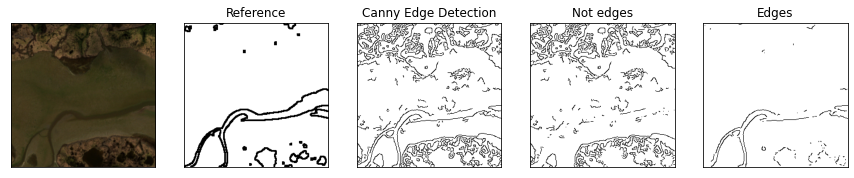

In [47]:
rint = random.randint(0,98)
print(rint)


preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]


r = edge_reference[rint]*1.0
print(r.min(),r.max())

c = 2
canny = [canny_ed(img) for img in preprocess_input][rint][:,:,c]*1.0
print(canny.min(),canny.max())

non_edge =  np.array(canny)-np.array(r)
non_edge = np.clip(non_edge,0,255)
print(non_edge.min(),non_edge.max())

edge = np.clip(non_edge,0,255)-np.array(canny)
print(edge.min(),edge.max())

fig, axs = plt.subplots(1,5, figsize=(15,15))

axs[0].imshow(rgb[rint])

axs[1].imshow(255-r,cmap="gray")
axs[1].set_title("Reference")
axs[2].imshow(255-canny,cmap="gray")
axs[2].set_title("Canny Edge Detection")
axs[3].imshow(255-non_edge,cmap="gray")
axs[3].set_title("Not edges")
axs[4].imshow(edge,cmap="gray")
axs[4].set_title("Edges")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
